# NBA Salary Prediction


<img src='https://www.mercurynews.com/wp-content/uploads/2020/03/BNG-L-WARRIORS-0306-7.jpg?w=525' style='float: center'>



## Problem Statement: 
Over the past few years, NBA players have received large contracts -around 40 million usd annual -as compared to those in the 2000s, where the highest salary was 20 million USD. Are the players today overpaid? In addition, Power Forwards or Centers, positions that were previously known for dominating in the paint, are developing a 3-point shot. In fact, the players have evolved from those who were unstoppable in mid-range and inside the paint (Shaquille O'Neal, Kevin Garnett, Tim Duncan) to those with an outside touch (Karl-Anthony Towns, Anthony Davis, Kristap Porzingis). 

Is this a requirement to be able to succeed in today's game? 

## Objective:
Predict the expected salary of a player based from his performance the past year and/or the historical dataset for the past 20 years. 

## Assumptions:

Players are accepting the largest contract they are offered by teams, instead of leaving money on the table. 
I am looking how well they perform on average per game from past last season.
There is a correlation between a player's performance and the contract they have, but there should be certain stats (features) that have a stronger correlation than others. 


## Notes:

Rookies' contracts are not included in this dataset, as they do not have participated in NBA games yet.

### Steps Guide:
- [Web Scraping](./WebScraping.ipynb)
- [Cleaning Data](#data-cleaning)
- [Machine Learning Models](#machine-learning) 
 - [Linear Regression](#linear-regression)
 - [Random Forest Regression](#random-forest-regression)
 - [XGBoost Regression](#XGBoost-regression)
 - [Conclusion](#Conclusion)

<a id="data-cleaning"></a>
## Cleaning the Data
--- 

####  Combine the salary csv with the stats csv, and perform necessary changes.

In [190]:
#Import the necessary modules for the whole notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cpi
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sys
import xgboost as xgb
from xgboost import XGBRegressor
%matplotlib inline

from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['font.size'] = 14

In [10]:
#Create Salary and Stats dataframe
salary = pd.read_csv('./data/salary.csv')
stats = pd.read_csv('./data/stats.csv')

In [11]:
#Change those with special characters
#Drop duplicates, for those were traded midway.
stats = stats.drop_duplicates(['Player','Year'],keep='first',ignore_index=True) #Drop duplicates.
stats['Player']=stats['Player'].str.replace('*','')#remove the asterisk
stats['Player']=stats['Player'].str.replace('ć','c')#remove special characters
stats['Player']=stats['Player'].str.replace('č','c')
stats['Player']=stats['Player'].str.replace('á','a')
stats['Player']=stats['Player'].str.replace('.','')

#show salary in terms of millions.
salary.Salary = salary.Salary/1000000

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


#### Calculation Inflation Rate

In [12]:
# #Account for inflation by using CPI Method

# def inflate(salary,year):
#     if year == 2020:
#         return salary
#     elif year == 2019:
#         return salary * 1.023
#     else:
#         return cpi.inflate(salary,year)

# def inflation_column(df,column):
#     """
#     Adjust for inflation the series of values in column of the   
#     dataframe data
#     """
#     return df.apply(lambda x: inflate(x[column],x.Year),axis=1)



# salary['Salary'] = inflation_column(salary,'Salary')

# #Verification
# # salary[salary.Player.str.contains('Shaq')]
# # salary[salary.Player.str.contains('Rudy Gobert')]

#### Salary and Stats DataFrame Verification.

Use Stephen Curry's 2020 salary as a sample comparison for our models.

In [19]:
#Salary DataFrame
salary[salary['Player'].str.contains('Stephen Curry')]    #We get Steph Curry's 2020 Salary and use it to test our models.

,Player,Year,Salary
4418,Stephen Curry,2009,3.172602
4859,Stephen Curry,2010,3.355494
5301,Stephen Curry,2011,3.479746
5740,Stephen Curry,2012,4.329677
6116,Stephen Curry,2013,10.658002
6606,Stephen Curry,2014,11.274457
7124,Stephen Curry,2015,12.046748
7641,Stephen Curry,2016,12.672539
8105,Stephen Curry,2017,35.529663
8691,Stephen Curry,2018,37.457154


In [20]:
#Ensure no null/missing values
salary.isnull().sum()

Player    0
Year      0
Salary    0
dtype: int64

In [21]:
#Stats DataFrame Verification
stats[stats['Player'].str.contains('Stephen Curry')]

,Player,Year,POS,Age,TM,GP,GS,MP,FGM,FGA,...,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF,PTS
4563,Stephen Curry,2010,PG,21,GSW,80,77,36.2,6.6,14.3,...,0.885,0.6,3.9,4.5,5.9,1.9,0.2,3.0,3.2,17.5
5007,Stephen Curry,2011,PG,22,GSW,74,74,33.6,6.8,14.2,...,0.934,0.7,3.2,3.9,5.8,1.5,0.3,3.1,3.1,18.6
5459,Stephen Curry,2012,PG,23,GSW,26,23,28.2,5.6,11.4,...,0.809,0.6,2.8,3.4,5.3,1.5,0.3,2.5,2.4,14.7
5932,Stephen Curry,2013,PG,24,GSW,78,78,38.2,8.0,17.8,...,0.900,0.8,3.3,4.0,6.9,1.6,0.2,3.1,2.5,22.9
6414,Stephen Curry,2014,PG,25,GSW,78,78,36.5,8.4,17.7,...,0.885,0.6,3.7,4.3,8.5,1.6,0.2,3.8,2.5,24.0
6896,Stephen Curry,2015,PG,26,GSW,80,80,32.7,8.2,16.8,...,0.914,0.7,3.6,4.3,7.7,2.0,0.2,3.1,2.0,23.8
7381,Stephen Curry,2016,PG,27,GSW,79,79,34.2,10.2,20.2,...,0.908,0.9,4.6,5.4,6.7,2.1,0.2,3.3,2.0,30.1
7850,Stephen Curry,2017,PG,28,GSW,79,79,33.4,8.5,18.3,...,0.898,0.8,3.7,4.5,6.6,1.8,0.2,3.0,2.3,25.3
8358,Stephen Curry,2018,PG,29,GSW,51,51,32.0,8.4,16.9,...,0.921,0.7,4.4,5.1,6.1,1.6,0.2,3.0,2.2,26.4
8902,Stephen Curry,2019,PG,30,GSW,69,69,33.8,9.2,19.4,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3


#### Combine both the salary and stats dataframe.

In [22]:
df = pd.merge(salary,stats,on=['Player','Year'],how='left')
df.shape

(10319, 30)

In [23]:
#Drop the values with NA, as most of them are rookies with contracts.
df=df.dropna(axis='rows').reset_index(drop=True)

In [24]:
#Check for null values that resulted from our join method.
df.isnull().sum()

Player    0
Year      0
Salary    0
POS       0
Age       0
TM        0
GP        0
GS        0
MP        0
FGM       0
FGA       0
FG%       0
3PM       0
3PA       0
3P%       0
2PM       0
2PA       0
2P%       0
FTM       0
FTA       0
FT%       0
ORB       0
DRB       0
REB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

#### When a person gets traded to another team during the season, there is a high chance he will change position as well, depending how the team acquiring him will utilize him within the team. For example, Robert Covington was regarded as a Small Forward on the Philadelphia 76ers, but he became a Center when he was traded to the Houston Rockets in 2019.  <br><br> Thus, we will take the 1st position, as this was their original position associated with their salary for the start of the season.

In [25]:
df['POS'].value_counts()

SG       1570
PG       1434
SF       1347
PF       1336
C         997
PG-SG      22
SF-SG      22
C-PF       13
PF-SF      12
SF-PF      12
PF-C       12
SG-PG      11
SG-SF       9
SG-PF       4
PG-SF       1
SF-C        1
Name: POS, dtype: int64

In [26]:
df['POS']=df['POS'].str.split("-",expand=True)[0]
df['POS'].value_counts()

SG    1594
PG    1457
SF    1382
PF    1360
C     1010
Name: POS, dtype: int64

#### Compare the average salaries, and 3 pointers made (3PM) throughout the past 20 years.

In [20]:
# mean salaries is in millions.
df.groupby(['Year','POS'])['Salary'].agg(['mean']) 

mean
Year POS           
2000 C     9.298772
     PF    7.549561
     PG    4.681793
     SF    5.077988
     SG    5.343863
...             ...
2020 C     7.960117
     PF    8.786709
     PG   11.947412
     SF    7.834022
     SG    7.181959

[105 rows x 1 columns]

#### Plot the average salary for each position throughout the years.

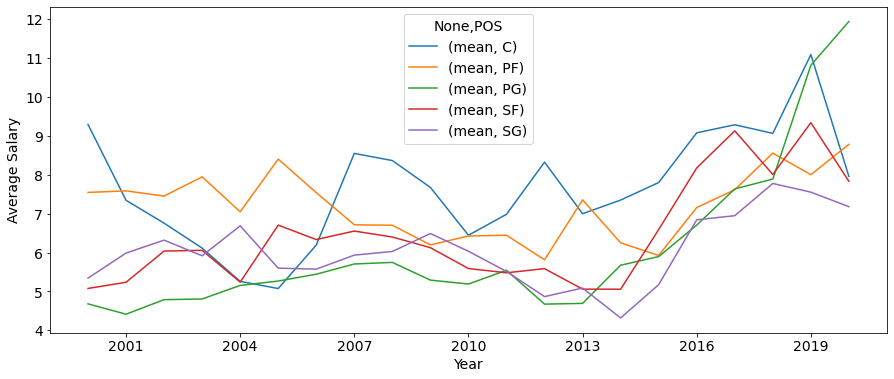

In [27]:
fig, ax = plt.subplots(figsize=(15,6));


df.groupby(['Year','POS'])['Salary'].agg(['mean']).unstack().plot(ax=ax,kind='line');
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) #set xticklabel to integer.

#Try to make hover show the values as well.
ax.set_xlabel("Year");
ax.set_ylabel("Average Salary");

#### Findings:
PG Salary ranked from lowest in 2000 to highest in 2020.<br>
C Salary ranked from highest in 2000 to close to bottom in 2020. 

#### Let's check the average 3 pointers made for each position as well.

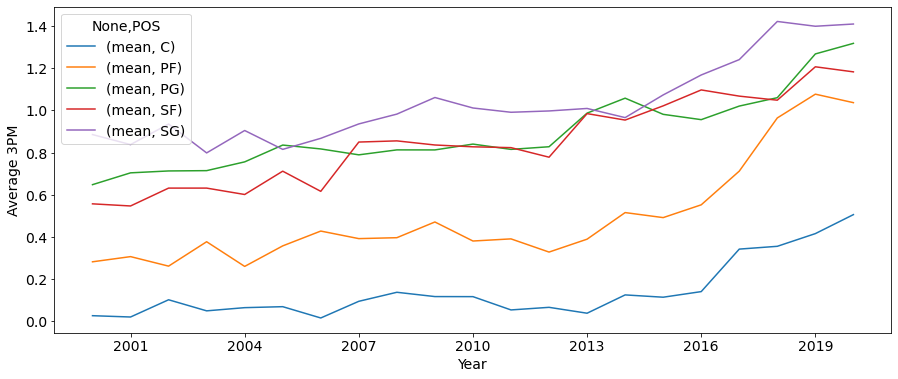

In [30]:
fig, ax = plt.subplots(figsize=(15,6));
df.groupby(['Year','POS'])['3PM'].agg(['mean']).unstack().plot(ax=ax,kind='line');
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) #set xticklabel to integer.
ax.set_xlabel("Year");
ax.set_ylabel("Average 3PM");

#### Findings:
The average salary of Point Guards dramatically increased from 2000.<br>
The average salary of Centers was ranked one of the highest in early 2000, but seen a sharp decrease in 2019.

## Machine Learning Models
<a id="machine-learning"></a>

Even though we have data from 2000, multiple dynamics have changed - 3 pointers have become more apparent.<br>
Fewer people are attempting mid-range jumpshots.<br>
Thus, I will use 2 different datasets to predict the salary using 3 machine learning models, and compare them against Stephen Curry's current salary of 43 million USD:<br> 
- (1)the past 5 years' dataset, and 
- (2) the whole dataset<br>


#### Create a dataframe for the past 5 years

In [32]:
#Create a recent years dataframe.
lastfiveyears_df=df[df.Year>=2015]

#### Since there are many confounding variables between one another, let's include the basic stats that dictate a player's performance. They are independent from one another, and are the preliminary indicators in a score stat sheet.
FG%, FT%, 3PM, PTS, REB,AST,STL,BLK,TOV,PF

In [34]:
lastfiveyears_df.head()

,Player,Year,Salary,POS,Age,TM,GP,GS,MP,FGM,...,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF,PTS
4659,Kobe Bryant,2015,26.486180,SG,36.0,LAL,35.0,35.0,34.5,7.6,...,0.813,0.7,4.9,5.7,5.6,1.3,0.2,3.7,1.9,22.3
4660,LeBron James,2015,24.336032,SF,30.0,CLE,69.0,69.0,36.1,9.0,...,0.710,0.7,5.3,6.0,7.4,1.6,0.7,3.9,2.0,25.3
4661,Carmelo Anthony,2015,24.234855,SF,30.0,NYK,40.0,40.0,35.7,9.0,...,0.797,1.8,4.8,6.6,3.1,1.0,0.4,2.2,2.2,24.2
4662,Dwight Howard,2015,23.688566,C,29.0,HOU,41.0,41.0,29.8,6.1,...,0.528,2.7,7.8,10.5,1.2,0.7,1.3,2.8,3.3,15.8
4663,Joe Johnson,2015,23.635572,SG,33.0,BRK,80.0,80.0,34.9,5.6,...,0.801,0.7,4.1,4.8,3.7,0.7,0.2,1.7,1.5,14.4


### 1. Linear Regression Model: 
<a id="linear-regression"></a>
- Create a feature column.
- Apply feature scaling
- Preliminary Regression Model
- K-Fold Cross Validation (5)

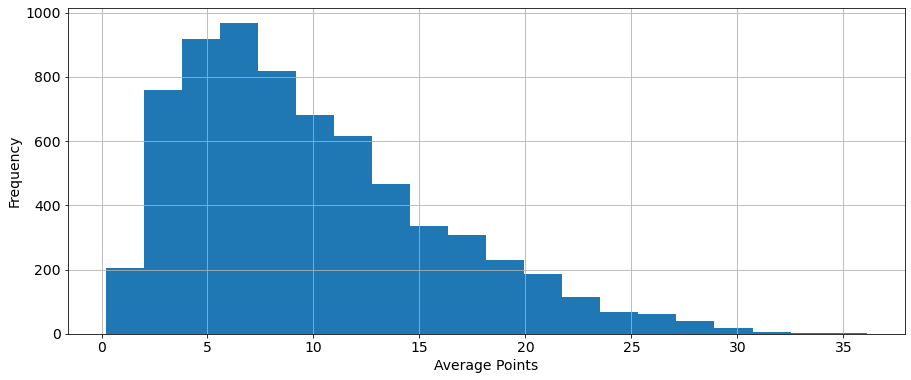

In [184]:
#Create a list of features
feature_cols=['PTS','FG%','FT%','3PM','AST','REB','STL','BLK','TOV','PF']

#Distribution of Points
fig, ax = plt.subplots(figsize=(15,6));
df.PTS.hist(bins=20);
ax.set_xlabel("Average Points");
ax.set_ylabel("Frequency");

In [120]:
#Create X and Y
X_5 = lastfiveyears_df[feature_cols]
y_5 = lastfiveyears_df.Salary

X = df[feature_cols]
y = df.Salary

#### Preliminary Linear Regression Model

Do a Train Test Split with size 0.2

In [121]:
#for df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#for 5 years df
X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X_5, y_5, test_size=0.2, random_state=123)

In [122]:
linreg = LinearRegression()
linreg_5 = LinearRegression()
linreg.fit(X_train,y_train)
linreg_5.fit(X_5_train,y_5_train)
score = linreg.score(X_test, y_test)
score_5 = linreg_5.score(X_5_test, y_5_test)
print("R^2-value for df:{}".format(round(score,3)))
print("R^2-value for 5 years df:{}".format(round(score_5,3)))

R^2-value for df:0.552
R^2-value for 5 years df:0.612


In [123]:
#for df
print('Intercept: {}'.format(round(linreg.intercept_,3)))
for i, j in list(zip(feature_cols,linreg.coef_)):
    print('Coefficient for {}: {}'.format(i,j))
print('\n')
#for 5 years df
print('Intercept_5: {}'.format(round(linreg_5.intercept_,3)))
for i, j in list(zip(feature_cols,linreg_5.coef_)):
    print('Coefficient for {}_5: {}'.format(i,j))

Intercept: 1.31
Coefficient for PTS: 0.5381964974465909
Coefficient for FG%: -1.7998946394719206
Coefficient for FT%: -1.9146104449784058
Coefficient for 3PM: 1.0323162011984055
Coefficient for AST: 0.8288080829790927
Coefficient for REB: 0.806337407102995
Coefficient for STL: -1.2300809879615724
Coefficient for BLK: 1.1178568046805735
Coefficient for TOV: -0.8627694458879376
Coefficient for PF: -0.9772292576916762


Intercept_5: -0.729
Coefficient for PTS_5: 0.6477357667088811
Coefficient for FG%_5: 0.029507624033217494
Coefficient for FT%_5: -1.44265424771588
Coefficient for 3PM_5: 1.2851157239993904
Coefficient for AST_5: 1.3248349044010777
Coefficient for REB_5: 1.0876671159852525
Coefficient for STL_5: 0.4105021009800016
Coefficient for BLK_5: 1.1595977391634953
Coefficient for TOV_5: -1.9350150422166195
Coefficient for PF_5: -1.8361379887487637


Findings:
- Points, 3 pointers made, as well as assists, matter more significantly for the past 5 years.

#### Create Train/Test Split: K-Folds Cross (5)

In [124]:
scores = cross_val_score(linreg, X, y, cv=5, scoring='neg_mean_squared_error')
scores_5 = cross_val_score(linreg_5, X_5, y_5, cv=5, scoring='neg_mean_squared_error')
mse_error = np.mean(np.sqrt(-scores))
mse_error_5 = np.mean(np.sqrt(-scores_5))
print ('Mean squared error for df: {}'.format(mse_error))
print ('Mean squared error for 5 years df: {}'.format(mse_error_5))

Mean squared error for df: 4.660007212530926
Mean squared error for 5 years df: 5.483980585845383


#### Compare Stephen Curry's stats this year and test it!
*Note that Stephen Curry's salary is around 43 million USD. We compare it with our predicted salary through the machine learning models.*

In [126]:
#feature_cols=['PTS','FG%','FT%','3PM','AST','REB','STL','BLK','TOV','PF']
steph_test = np.array([[27.9,0.453,0.926,4.2,6.2,5.6,1.2,0.2,3.4,2.3]])
linreg.fit(X_train,y_train)
steph_pred = linreg.predict(steph_test.reshape(1,-1))
print('Through Linear Regression for the whole dataset of 20 years, predicted Salary for Stephen Curry is {} million USD.'.format(round(steph_pred[0],2)))
steph_pred_5 = linreg_5.predict(steph_test.reshape(1,-1))
print('Through Linear Regression for the past 5 years dataset, predicted Salary for Stephen Curry is {} million USD.'.format(round(steph_pred_5[0],2)))

Through Linear Regression for the whole dataset of 20 years, predicted Salary for Stephen Curry is 21.29 million USD.
Through Linear Regression for the past 5 years dataset, predicted Salary for Stephen Curry is 25.65 million USD.


### 2. Random Forest Regression Model
<a id="random-forest-regression"></a>

#### Create Random Forest Regression Preliminary Model

In [128]:
#Initiate the random forest regressor object.
rfreg = RandomForestRegressor(n_estimators=150, max_features=10, oob_score=True, random_state=123)
rfreg_5 = RandomForestRegressor(n_estimators=150, max_features=10, oob_score=True, random_state=123)
rfreg.fit(X_train, y_train)
rfreg_5.fit(X_5_train, y_5_train)


RandomForestRegressor(max_features=10, n_estimators=150, oob_score=True,
                      random_state=123)

#### Compute feature importance

In [149]:
rf=pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)
rf_5=pd.DataFrame({'feature':feature_cols, 'importance':rfreg_5.feature_importances_}).sort_values(by='importance',ascending=False)
rf_55 = rf_5.rename(columns={'feature':'feature_5','importance':'importance_5'})
display_side_by_side(rf,rf_55)

,feature,importance
0,PTS,0.496105
5,REB,0.090596
2,FT%,0.067682
4,AST,0.067349
1,FG%,0.061459
3,3PM,0.056719
9,PF,0.047752
8,TOV,0.038676
6,STL,0.038228
7,BLK,0.035433


In [153]:
# Compute the out-of-bag R-squared score.
print('Oob-score:{}'.format(rfreg.oob_score_))
print('Oob-score_5:{}'.format(rfreg_5.oob_score_))
print('The accuracy score is much lesser than that of the linear regression model we have respectively (0.55, 0.612)')

Oob-score:0.5206259196043708
Oob-score_5:0.5674379902685704
The accuracy score is much lesser than that of the linear regression model we have respectively (0.55, 0.612)


#### Do a 5-fold and compute the mean squared error. 

In [154]:
import numpy as np
# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
scores_5 = cross_val_score(rfreg, X_5, y_5, cv=5, scoring='neg_mean_squared_error')
mse_error = np.mean(np.sqrt(-scores))
mse_error_5 = np.mean(np.sqrt(-scores_5))

print ('Mean squared error: {}'.format(mse_error))
print ('Mean squared error for 5 years : {}'.format(mse_error_5))

Mean squared error: 4.677191726814769
Mean squared error for 5 years : 5.418962808018819


#### Note: Mean-squared error for the whole data set is larger than that of linear regression, while mean-squared error for the past 5 years is smaller than that of linear regression.

### Hyperparameter Tuning

#### 1. Tuning n_estimators:

In [160]:
estimator_range = list(range(10,310,10))

#List to store the average RMSE for each value of n_estimators:
RMSE_scores = []
RMSE_scores_5 = []

#Use five-fold cross-validation with each value of n_estimators:
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores_5 = cross_val_score(rfreg, X_5, y_5, cv=5, scoring = 'neg_mean_squared_error')
    RMSE_scores_5.append(np.mean(np.sqrt(-MSE_scores_5)))
    
# for estimator in estimator_range:
#     rfreg_5 = RandomForestRegressor(n_estimators=estimator, random_state=1)
#     MSE_scores_5 = cross_val_score(rfreg, X_5, y_5, cv=5, scoring = 'neg_mean_squared_error')
#     RMSE_scores_5.append(np.mean(np.sqrt(-MSE_scores)))

In [145]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

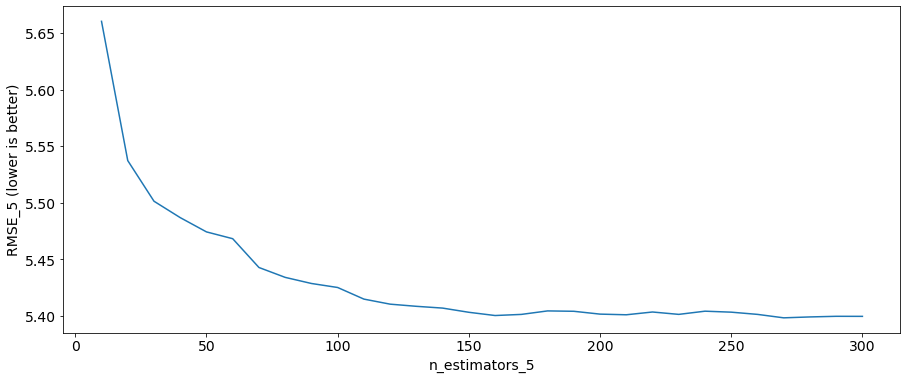

In [161]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

# plt.plot(estimator_range, RMSE_scores);
# plt.xlabel('n_estimators');
# plt.ylabel('RMSE (lower is better)');

plt.plot(estimator_range, RMSE_scores_5);
plt.xlabel('n_estimators_5');
plt.ylabel('RMSE_5 (lower is better)');

In [162]:
# Show the best RMSE and the corresponding max_features.
#sorted(zip(RMSE_scores, estimator_range))[0]
sorted(zip(RMSE_scores_5, estimator_range))[0]

(5.398326696613663, 270)

Based from the results, we should set n_estimators to be 270.

#### 2.Tuning max_features: 

In [148]:
feature_range = list(range(1,len(feature_cols)+1))

#List to store the average RMSE for each value of max_feature:
RMSE_scores = []

#Use five-fold cross-validation with each value of max_feature:
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring = 'neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

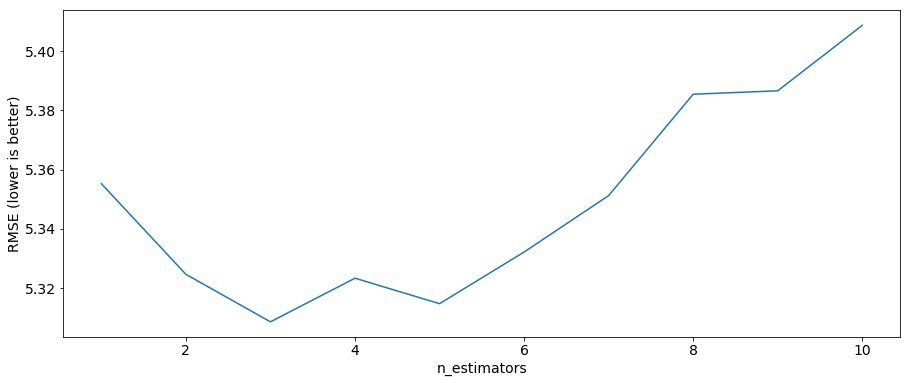

In [150]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [ ]:
sorted(zip(RMSE_scores, feature_range))[0]
print('Seems like 3 is the ideal number of estimators we can have.')

#### *Again, predict Stephen Curry's salary!*

In [155]:
rfreg = RandomForestRegressor(n_estimators=20, max_features=3, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=None, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [156]:
steph_pred = rfreg.predict(steph_test.reshape(1,-1))
print('Through Random Forest Regression, predicted Salary for Stephen Curry is {} million USD.'.format(round(steph_pred[0],2)))

Through Random Forest Regression, predicted Salary for Stephen Curry is 30.25 million USD.


### 3. Predicting Salary with XGBoost
<a id="XGBoost-regression"></a>

#### Preliminary XGBoost Model

Create a Data Matrix, and initiate the XGBRegressor object.

In [163]:
data_dmatrix = xgb.DMatrix(data=X_5,label=y_5)

List Parameter Range for input into the RandomizedSearchCV function.

In [210]:
params = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25],
    "max_depth": list(range(1,11,1)),
     "min_child_weight": [1,3,5,7],
     "gamma":[0.0,0.1,0.2,0.3,0.4],
     "colsample_bytree":[0.1,0.2,0.3,0.4]
}

In [257]:
xgbr = XGBRegressor()
random_search = RandomizedSearchCV(xgbr, param_distributions = params, n_iter = 10, n_jobs = -1,cv=5,verbose=0)
random_search.fit(X_5,y_5)

[18:22:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.2, 0.3,
                                                             0.4],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 3, 5, 7]})

Find the best parameters and use it to run the xgBoosting.

In [217]:
random_search.best_estimator_

XGBRegressor(colsample_bytree=0.4, gamma=0.3, max_depth=7, min_child_weight=3)

In [232]:
best_params = random_search.best_params_

Boost for 100 rounds with the best parameters chosen.

In [245]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=best_params, nfold=5,
                    num_boost_round=100,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.329466,0.053927,10.383705,0.219252
1,9.568111,0.048910,9.685135,0.215152
2,8.919424,0.051565,9.116577,0.198826
3,8.334500,0.043539,8.601779,0.210863
4,7.812209,0.044367,8.179823,0.225903


In [248]:
final_rmse = cv_results["test-rmse-mean"].tail(1)

In [249]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print("RMSE: %f" % (final_rmse))
print("Our RMSE is similar to that of the Random Forest Regression Model.")

RMSE: 5.476748
Our RMSE is similar to that of the Random Forest Regression Model.


#### Now, we find Find the feature importance for the XGBR Model.

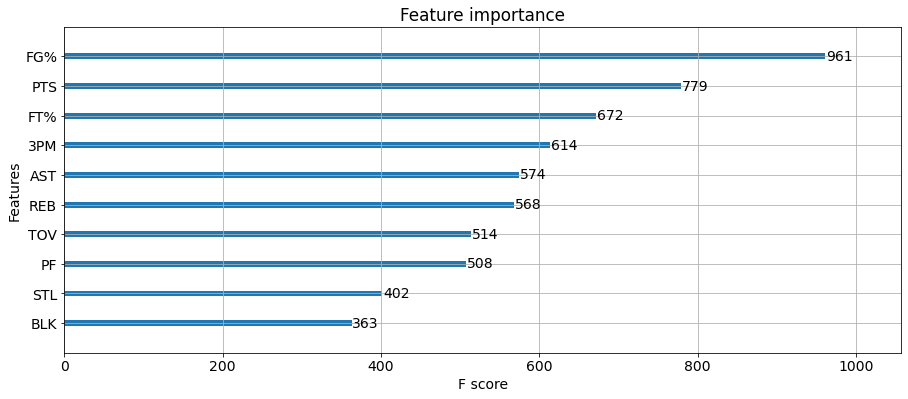

In [260]:
xgbr = XGBRegressor(colsample_bytree=0.4, gamma=0.3, max_depth=7, min_child_weight=3, silent=True )
xgbr.fit(X_5_train, y_5_train)
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Seems like efficiency matters here!

#### *Again, we predict Steph's Salary!*

In [250]:
steph_test
steph_df=pd.DataFrame(steph_test,columns=feature_cols)

In [255]:
xgbr = XGBRegressor(colsample_bytree=0.4, gamma=0.3, max_depth=7, min_child_weight=3, silent=True )
xgbr.fit(X_5_train, y_5_train)
steph_pred = xgbr.predict(steph_df)
steph_pred = round(steph_pred[0],2)
print('Through XGBoost Regression, predicted Salary for Stephen Curry is {} million USD.'.format(steph_pred))

Through XGBoost Regression, predicted Salary for Stephen Curry is 26.649999618530273 million USD.


<a id="conclusion"></a>
## Conclusion

- Random Forest seems to be the best model we have, as it is the one closest to Steph Curry's salary of 43 million USD.
- It also has a very low RMSE, along XGBoost.
- Improvements could be made:
    - Salary (target data) distribution could be an exponential graph, so perhaps it would be better if we transform    it with Ln first
- More advanced categories could be used instead. 